<a href="https://colab.research.google.com/github/AilingLiu/From-Business-Insights-to-Action/blob/master/Customer_Segmentation_by_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

Check [here](https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444) to understand what is RFM. 

- R: recency, the last time that customer being active till the point of analysis
- F: frequency, how frequent the customer is using the product/being online
- M: monetary, how much revenue company gained from the customer

RFM is one of the traditional measurements of customer segmentation. Customer segmentation gives your company direction where to put retention efforts.

In the article referred above, the author calculate the frequency and revenue from customer alive till analysis point. As far as I am concerned, this will reduce the RFM score from new clients, who only starts to use the product recently, so high revenue and high frequency are unlikely. 

Moreoever, the author uses KMeans to categorize each RFM metric. Here, I will be only using percentile of where the customer's RFM sits in the sample as label.

After creating the RFM score, I will use segement the customer groups by popular segmentation standards.

# Get the data

In [2]:
url = 'https://github.com/AilingLiu/Growth_Analysis/blob/master/Data/online_retail.csv?raw=true'

data = pd.read_csv(url, sep=',', parse_dates=['InvoiceDate'], encoding='latin-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [0]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Clean up data

In [0]:
# clean up the negative quantity and unit price
df = data.loc[(data['Quantity'] >=0)&(data['UnitPrice']>=0), :]

# clean up rows where customerid is unknown
mask =df['CustomerID'].isnull() 
df = df.loc[~mask, :]

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      397924 non-null object
StockCode      397924 non-null object
Description    397924 non-null object
Quantity       397924 non-null int64
InvoiceDate    397924 non-null datetime64[ns]
UnitPrice      397924 non-null float64
CustomerID     397924 non-null float64
Country        397924 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [0]:
df['CustomerID'].nunique()

4339

We have 4339 unique customers after cleaning.

In [0]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


## Grouping based on RFM

In [4]:
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']

gb=df.groupby(['CustomerID']).agg(
    Last_Order_Date=('InvoiceDate', 'max'),
    Total_Orders=('InvoiceNo', 'nunique'),
    Total_Revenue=('TotalPrice', 'sum'))

gb.head()

,Last_Order_Date,Total_Orders,Total_Revenue
CustomerID,,,
12346.0,2011-01-18 10:01:00,1,77183.60
12347.0,2011-12-07 15:52:00,7,4310.00
12348.0,2011-09-25 13:13:00,4,1797.24
12349.0,2011-11-21 09:51:00,1,1757.55
12350.0,2011-02-02 16:01:00,1,334.40


# create recency index

Recency: Data collection date - customer last invoice date

In [0]:
m = gb['Last_Order_Date'].max().normalize()

diff = lambda x: (m-x.normalize()).days
gb['Recency'] = gb['Last_Order_Date'].transform(diff)

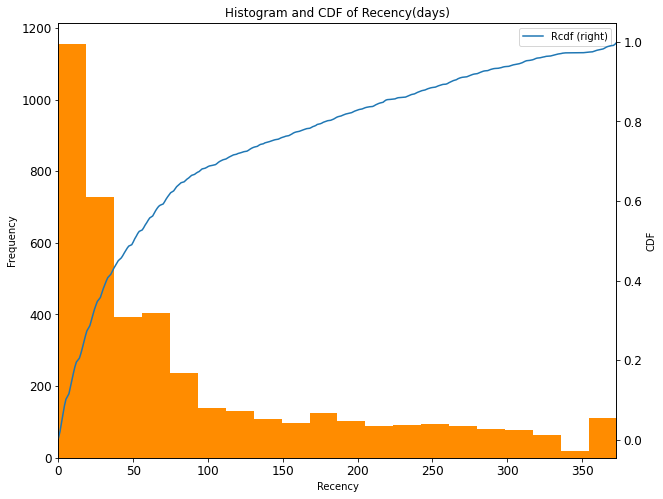

In [6]:
gb['Rcdf']= gb['Recency'].rank(method = 'average', pct = True)

ax1 =gb['Recency'].plot.hist(bins=20, 
                        figsize=(10, 8),
                        color='DarkOrange',
                        title='Histogram and CDF of Recency(days)')

ax2=gb.sort_values('Recency').plot(x='Recency', 
                                  y='Rcdf',
                                  ax=ax1,
                                  secondary_y=True)
ax2.set_ylabel('CDF')
plt.xlabel('Recency(days)')
plt.show()

In [0]:
gb['Recency'].describe()

count    4339.000000
mean       92.041484
std       100.007757
min         0.000000
25%        17.000000
50%        50.000000
75%       141.500000
max       373.000000
Name: Recency, dtype: float64

50% of the customers have recency within the last 50 days, among which 25% of them have recency within 17 days. About 25% of customers have more than 5 months recency.

A good way to categorize the Recency is to use percentile. Here we can cut it into four categories [.25, .5, .75, 1], based on percentile.


In [116]:
gb['RecencyInd'] = pd.qcut(gb['Recency'], 4, labels=[1, 2, 3, 4])
gb.groupby('RecencyInd')['Recency'].max()

RecencyInd
1     17
2     50
3    141
4    373
Name: Recency, dtype: int64

# create frequency index

My interest of frequncy is the total number of orders customer placd, while the author from the reference blog consider total invoice date as frequency meansurement. 

In [0]:
gb['Total_Orders'].describe()

count    4339.000000
mean        4.271952
std         7.705493
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       210.000000
Name: Total_Orders, dtype: float64

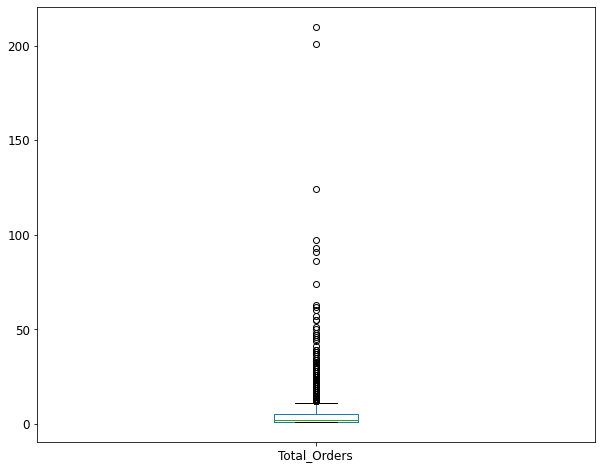

In [0]:
gb['Total_Orders'].plot(kind='box',
                        figsize=(10, 8))
plt.show()

There is a long whisker at the upper end. Some customers place much more orders than others on average.

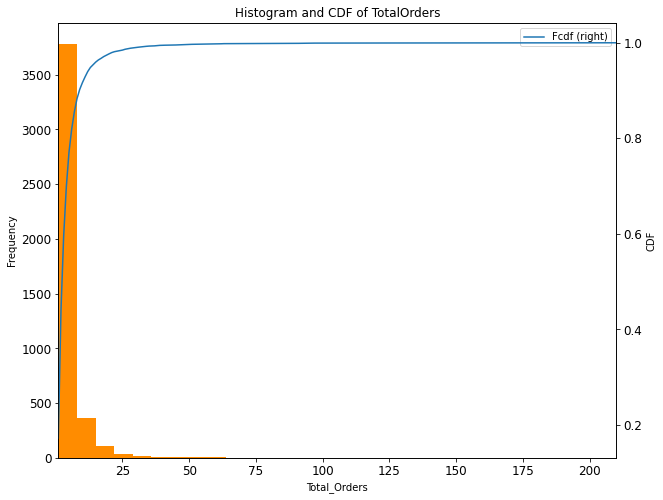

In [8]:
gb['Fcdf']= gb['Total_Orders'].rank(method = 'average', pct = True)

ax1 =gb['Total_Orders'].plot.hist(bins=30, 
                        figsize=(10, 8),
                        color='DarkOrange',
                        title='Histogram and CDF of TotalOrders')

ax2=gb.sort_values('Total_Orders').plot(x='Total_Orders', 
                                  y='Fcdf',
                                  ax=ax1,
                                  secondary_y=True)
ax2.set_ylabel('CDF')
plt.xlabel('Total_Orders')
plt.show()

About 95% of the customers placed less than 25 orders. Here, we will split the customers into total orders quantiles as [.5, .75, .95, 1], the corresponding minimum orders for each category is: 1, 3, 6, 14. Company naturally would invest more efforts in serving customer with more orders, i.e. the last category.

In [120]:
gb['FrequencyInd'] = pd.qcut(gb['Total_Orders'], q=[0, 0.5, 0.75, 0.95, 1], labels=[4,3,2,1])
gb.groupby('FrequencyInd')['Total_Orders'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyInd,,,,,,,,
4,2329.0,1.358523,0.479670,1.0,1.0,1.0,2.00,2.0
3,1138.0,3.767135,0.778612,3.0,3.0,4.0,4.00,5.0
2,662.0,8.264350,2.132785,6.0,6.0,8.0,10.00,13.0
1,210.0,26.733333,23.637723,14.0,16.0,20.0,27.75,210.0


 # create revenue index

In [0]:
gb['Total_Revenue'].describe()

count      4339.000000
mean       2053.793018
std        8988.248381
min           0.000000
25%         307.245000
50%         674.450000
75%        1661.640000
max      280206.020000
Name: Total_Revenue, dtype: float64

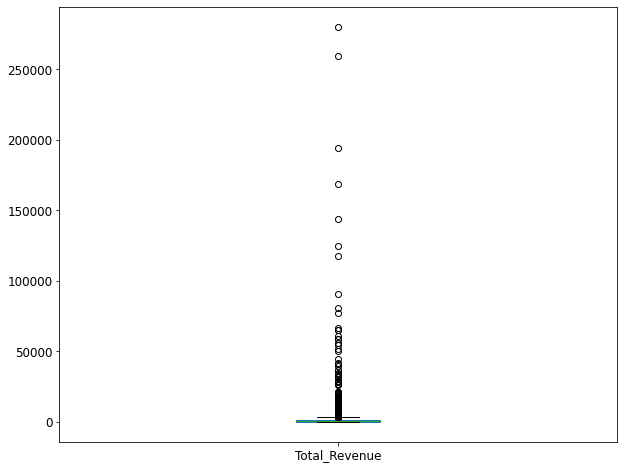

In [0]:
gb['Total_Revenue'].plot(kind='box',
                         figsize=(10, 8))
plt.show()

Let's of outliers. It's highly skewed to the right.

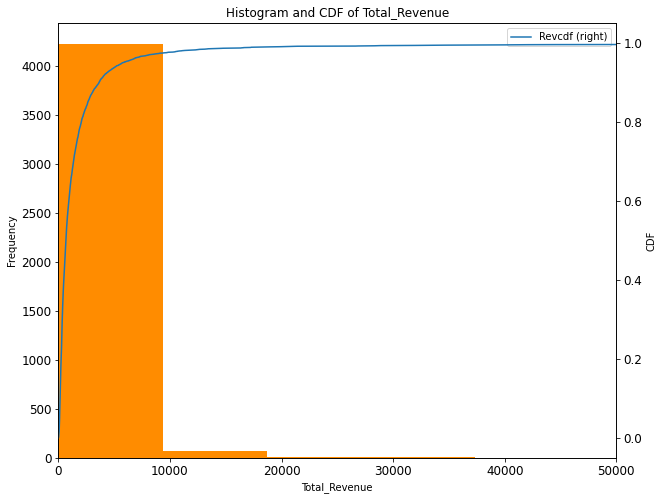

In [10]:
gb['Revcdf']= gb['Total_Revenue'].rank(method = 'average', pct = True)

ax1 =gb['Total_Revenue'].plot.hist(bins=30, 
                        figsize=(10, 8),
                        color='DarkOrange',
                        xlim=(0, 50000),
                        title='Histogram and CDF of Total_Revenue')

ax2=gb.sort_values('Total_Revenue').plot(x='Total_Revenue', 
                                  y='Revcdf',
                                  xlim=(0, 50000),
                                  ax=ax1,
                                  secondary_y=True)
ax2.set_ylabel('CDF')
plt.xlabel('Total_Revenue')
plt.show()

In [0]:
gb['Total_Revenue'].quantile([0,0.5,0.75, 0.95, 1])

0.00         0.000
0.50       674.450
0.75      1661.640
0.95      5840.182
1.00    280206.020
Name: Total_Revenue, dtype: float64

On average, customers spend 674 dollars. 

In [118]:
gb['RevInd'] = pd.qcut(gb['Total_Revenue'], q=[0, 0.5, 0.75, 0.95, 1], labels=[4,3,2,1])
gb.groupby('RevInd')['Total_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevInd,,,,,,,,
4,2170.0,321.643752,170.577228,0.00,177.1900,307.245,447.6700,674.45
3,1084.0,1071.859143,282.132341,674.52,820.6475,1031.025,1299.4850,1661.44
2,868.0,2951.780462,1071.278907,1661.84,2058.8100,2639.055,3646.3475,5836.86
1,217.0,20688.480230,35073.151824,5870.08,7044.6800,9736.520,16587.0900,280206.02


# Composite scores of RFM

In [105]:
incols = [col for col in gb.columns if 'Ind' in col]
incols

['RecencyInd', 'FrequencyInd', 'RevInd']

In [134]:
gb['TotalScore'] =  gb.RecencyInd.astype(str)+ gb.FrequencyInd.astype(str) + gb.RevInd.astype(str)
temp = gb.groupby(['TotalScore'])['Recency', 'Total_Orders', 'Total_Revenue'].median()
temp['Counts'] = gb.groupby('TotalScore').size()
temp = temp.reset_index()
temp.head()

,TotalScore,Recency,Total_Orders,Total_Revenue,Counts
0,111,3.0,25.0,11753.085,116
1,112,4.0,17.0,4424.610,56
2,121,10.0,11.0,8703.325,30
3,122,8.0,8.0,2892.195,254
4,123,8.0,7.0,1304.760,63


In [0]:
customer_cat = {'Best Customers': '111', 
                'High Spending New Customers': ['141', '142'],
                'Lowest Spending Active Loyal Customers': ['113', '114'],
                'Churned Best Customers': ['411', '412', '421', '422']}

def get_key(val): 
    for key, value in customer_cat.items(): 
         if val in value: 
             return key 

gb['CustomerType'] = gb['TotalScore'].transform(lambda x: get_key(x) if get_key(x) else 'Undefined')

## Best Customers

In [145]:
gb[gb['CustomerType']==list(customer_cat.keys())[0]].sort_values(by='Total_Revenue', ascending=False).head()

,Last_Order_Date,Total_Orders,Total_Revenue,Recency,Rcdf,RecencyInd,Fcdf,FrequencyInd,Revcdf,RevInd,TotalScore,CustomerType
CustomerID,,,,,,,,,,,,
14646.0,2011-12-08 12:12:00,74,280206.02,1,0.020051,1,0.998387,1,1.000000,1,111,Best Customers
18102.0,2011-12-09 11:50:00,60,259657.30,0,0.004148,1,0.997695,1,0.999770,1,111,Best Customers
17450.0,2011-12-01 13:29:00,46,194550.79,8,0.132749,1,0.995621,1,0.999539,1,111,Best Customers
14911.0,2011-12-08 15:54:00,201,143825.06,1,0.020051,1,0.999770,1,0.999078,1,111,Best Customers
14156.0,2011-11-30 10:54:00,55,117379.63,9,0.150035,1,0.997119,1,0.998617,1,111,Best Customers


## High Spending New Customers


In [146]:
gb[gb['CustomerType']==list(customer_cat.keys())[1]].sort_values(by='Total_Revenue', ascending=False).head()

,Last_Order_Date,Total_Orders,Total_Revenue,Recency,Rcdf,RecencyInd,Fcdf,FrequencyInd,Revcdf,RevInd,TotalScore,CustomerType
CustomerID,,,,,,,,,,,,
16446.0,2011-12-09 09:15:00,2,168472.50,0,0.004148,1,0.440655,4,0.999309,1,141,High Spending New Customers
15195.0,2011-12-07 12:20:00,1,3861.00,2,0.042291,1,0.172275,4,0.909657,2,142,High Spending New Customers
13868.0,2011-12-02 16:32:00,2,3192.54,7,0.115349,1,0.440655,4,0.882000,2,142,High Spending New Customers
12438.0,2011-11-25 13:28:00,2,2906.85,14,0.204886,1,0.440655,4,0.867251,2,142,High Spending New Customers
15123.0,2011-12-02 13:12:00,2,2199.31,7,0.115349,1,0.440655,4,0.813091,2,142,High Spending New Customers


## Lowest Spending Active Loyal Customers

In [147]:
gb[gb['CustomerType']==list(customer_cat.keys())[2]].sort_values(by='Total_Revenue', ascending=False).head()

,Last_Order_Date,Total_Orders,Total_Revenue,Recency,Rcdf,RecencyInd,Fcdf,FrequencyInd,Revcdf,RevInd,TotalScore,CustomerType
CustomerID,,,,,,,,,,,,


This category doesn't exist in this dataset.

## Churned Best Customers

In [151]:
gb[gb['CustomerType']==list(customer_cat.keys())[3]].sort_values(by='Total_Revenue', ascending=True).head()

,Last_Order_Date,Total_Orders,Total_Revenue,Recency,Rcdf,RecencyInd,Fcdf,FrequencyInd,Revcdf,RevInd,TotalScore,CustomerType
CustomerID,,,,,,,,,,,,
15235.0,2011-05-06 09:44:00,12,2247.51,217,0.848352,4,0.939617,2,0.818622,2,422,Churned Best Customers
16919.0,2011-07-06 13:35:00,11,2596.45,156,0.768495,4,0.928440,2,0.844204,2,422,Churned Best Customers
18260.0,2011-06-20 12:37:00,6,2643.20,172,0.789929,4,0.818968,2,0.850426,2,422,Churned Best Customers
17504.0,2011-05-17 12:59:00,9,2997.03,206,0.835676,4,0.902166,2,0.871629,2,422,Churned Best Customers
17230.0,2011-03-20 16:12:00,8,3638.41,264,0.902858,4,0.883038,2,0.898825,2,422,Churned Best Customers


Conclusion:

Here we only segment the customers into four groups. In reality, we should have drilled down to more classes for different marketing strategy. One of the segment standards from RFM scores will be [this](https://www.putler.com/rfm-analysis/#11segments), who has defined 9 categories, and detailed followed up action. Lots of RFM methods require to firstly categorize each RFM metric and then combine them into a single 'score'. Majority of the categorization methods are using equal quantitle. In my method, I use unequal quantile to give a label to the 'high spending' or 'most orders' customers. As the Pareto principle suggests, majority of the revenue come from 20% (or even less in video game, online retail, etc. industry) customers. The extreme high spending/total orders customers might often appear to be outliers in our dataset, but they might turn out to be the key revenue contributer. So giving a lable for such small group can highlight their importance in customer engagement.